<h1>Video Sliding Windows</h1>

<p>
So far we restricted ourselves to 1D time series, but the idea of recovering periodic dynamics with geometry can just as easily apply to multivariate signals.  In this module, we will examine sliding windows of videos as an exmaple.  Many natural videos also have periodicity, such as this video of a woman doing jumping jacks
</p>


In [1]:
import io
import base64
from IPython.display import HTML

video = io.open('jumpingjacks.ogg', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

<p>
Video can be decomposed into a 3D array, which has dimensions width x height x time.  To tease out periodicity in geometric form, we will do the exact same thing as with sliding window 1D signal embeddings, but instead of just one sample per time shift, we need to take every pixel in every frame in the time window.  The figure below depicts this
</p>

<img src = "VideoStackTime.svg"><BR><BR>

To see this visually in the video next to PCA of the embedding, look at the following video

In [2]:
video = io.open('jumpingjackssliding.ogg', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

<h2>PCA Preprocessing for Efficiency</h2><BR>
One issue we have swept under the rug so far is memory consumption and computational efficiency.  Doing a raw sliding window of every pixel of every frame in the video would blow up in memory.  However, even though there are <code>WH</code> pixels in each frame, there are only <code>N</code> frames in the video.  This means that each frame in the video can be represented in an <code>(N-1)</code> dimensional subspace of the pixel space, and the coordinates of this subspace can be used in lieu of the pixels in the sliding window embedding.  This can be done efficiently with a PCA step before the sliding window embedding.  Run the cell below to load code that does PCA efficiently

In [3]:
#Do all of the imports and setup inline plotting
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import scipy.interpolate

from TDA import *
from VideoTools import *

##Here is the actual PCA code
def getPCAVideo(I):
    ICov = I.dot(I.T)
    [lam, V] = linalg.eigh(ICov)
    V = V*np.sqrt(lam[None, :])
    return V

<h2>Jumping Jacks Example Live Demo</h2><BR>
Let's now load in code that does sliding window embeddings of videos.  The code is very similar to the 1D case, and it has the exact same parameters.  The only difference is that each sliding window lives in a Euclidean space of dimension the number of pixels times <code>dim</code>.  We're also using linear interpolation instead of spline interpolation to keep things fast

In [4]:
def getSlidingWindowVideo(I, dim, Tau, dT):
    N = I.shape[0] #Number of frames
    P = I.shape[1] #Number of pixels (possibly after PCA)
    pix = np.arange(P)
    NWindows = int(np.floor((N-dim*Tau)/dT))
    X = np.zeros((NWindows, dim*P))
    idx = np.arange(N)
    for i in range(NWindows):
        idxx = dT*i + Tau*np.arange(dim)
        start = int(np.floor(idxx[0]))
        end = int(np.ceil(idxx[-1]))+2
        if end >= I.shape[0]:
            X = X[0:i, :]
            break
        f = scipy.interpolate.interp2d(pix, idx[start:end+1], I[idx[start:end+1], :], kind='linear')
        X[i, :] = f(pix, idxx).flatten()
    return X

Finally, let's load in the jumping jacks video and perform PCA to reduce the number of effective pixels.  <BR>
<i>Note that loading the video may take a few seconds on the virtual image</i>



In [ ]:
#Load in video and do PCA to compress dimension
(X, FrameDims) = loadVideo("jumpingjacks.ogg")
X = getPCAVideo(X)

Now let's do a sliding window embedding and examine the sliding window embedding using TDA.  As before, you should tweak the parameters of the sliding window embedding and study the effect on the geometry.

In [ ]:
#Given that the period is 30 frames per cycle, choose a dimension and a Tau that capture 
#this motion in the roundest possible way
#Plot persistence diagram and PCA
dim = 30
Tau = 1
dT = 1

#Get sliding window video
XS = getSlidingWindowVideo(X, dim, Tau, dT)

#Mean-center and normalize sliding window
XS = XS - np.mean(XS, 1)[:, None]
XS = XS/np.sqrt(np.sum(XS**2, 1))[:, None]

#Get persistence diagrams
PDs = doRipsFiltration(XS, 1)

#Do PCA for visualization
pca = PCA(n_components = 3)
Y = pca.fit_transform(XS)


fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
plotDGMAx(ax1, PDs[1])
ax1.set_title("1D Persistence Diagram")

c = plt.get_cmap('jet')
C = c(np.array(np.round(np.linspace(0, 255, Y.shape[0])), dtype=np.int32))
C = C[:, 0:3]
ax2 = fig.add_subplot(122, projection = '3d')
ax2.set_title("PCA of Sliding Window Embedding")
ax2.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=C)
ax2.set_aspect('equal', 'datalim')
plt.show()

<h1>Periodicities in The KTH Dataset</h1><BR>

We will now examine videos from the <a href = "http://www.nada.kth.se/cvap/actions/">KTH dataset</a>, which is a repository of black and white videos of human activities.  It consists of 25 subjects performing 6 different actions in each of 4 scenarios.  We will use the algorithms developed in this section to measure and rank the periodicity of the different video clips.

<h2>Varying Window Length</h2><BR>
For our first experiment, we will be showing some precomputed results of varying the sliding window length, while choosing Tau and dT appropriately to keep the dimension and the number of points, respectively, the same in the sliding window embedding.  As an example, we will apply it to one of the videos of a subject waving his hands back and forth, as shown below

In [ ]:
video = io.open('KTH/handwaving/person01_handwaving_d1_uncomp.ogg', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

We have done some additional preprocessing, including applying a bandpass filter to each PCA pixel to cut down on drift in the video.  Below we show a video varying the window size of the embedding and plotting the persistence diagram, "self-similarity matrix" (distance matrix), and PCA of the embedding, as well as an evolving plot of the maximum persistence versus window size:

In [ ]:
video = io.open('Handwaving_Deriv10_Block160_PCA10.ogg', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

As you can see, the maximum persistence peaks at around 40 frames, which is the period of each hand wave.  This is what the theory we developed for 1D time series would have predicted as the roundest window.<BR>

<h2>KTH 4 Video Ranking</h2>
<BR>
Now, students will rank 4 videos from the database from most periodic to least periodic visually, and then we will run TDA on the videos and compare the ranking based on maximum persistence to the rank aggregated class estimate.  Click below to load the four videos.


In [ ]:
#First video
videos = ['KTH/handwaving/person01_handwaving_d1_uncomp.ogg']
video = io.open(videos[-1], 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<h1>Video 1</h1><video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

In [ ]:
videos.append('KTH/boxing/person01_boxing_d1_uncomp.ogg')
video = io.open(videos[-1], 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<h1>Video 2</h2><video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

In [ ]:
videos.append('KTH/walking/person01_walking_d1_uncomp.ogg')
video = io.open(videos[-1], 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<h1>Video 3</h1><video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

In [ ]:
videos.append('KTH/handwaving/person02_handwaving_d2_uncomp.ogg')
video = io.open(videos[-1], 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<h1>Video 4</h1><video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

Now that you have loaded in and watched the videos, go to the following Google doc and input your ranking, from most periodic to least.

Now, run the code below to compute a ranking based on delay embeddings and persistent homology.  The code goes through the video in blocks equal to 160 frames, hopping forward 80 frames to the next block, and it uses a fixed window size of 20 frames for all videos.  You can tweak these parameters if you'd like.  At the end, it records the maximum maximum persistence over all blocks of 160 frames.  

Do your rankings agree with the rankings returned by TDA?

In [ ]:
from KTHTests import *

#Setup video blocks
BlockLen = 160
BlockHop = 80
win = 20
dim = 20

scores = np.zeros(len(videos))
#Loop through each video and record the maximum persistence score
for i in range(len(videos)):
    (XOrig, FrameDims) = loadVideo(videos[i])
    X = getPCAVideo(XOrig)
    [X, validIdx] = getTimeDerivative(X, 10)

    idxs = []
    N = X.shape[0]
    NBlocks = int(np.ceil(1 + (N - BlockLen)/BlockHop))
    print("NBlocks = ", NBlocks)
    for k in range(NBlocks):
        thisidxs = np.arange(k*BlockHop, k*BlockHop+BlockLen, dtype=np.int64)
        thisidxs = thisidxs[thisidxs < N]
        idxs.append(thisidxs)

    res = np.zeros(NBlocks)

    #Get sliding window video in blocks
    maxXS = []
    maxPD = []
    for j in range(len(idxs)):
        idx = idxs[j]
        Tau = win/float(dim-1)
        dT = (len(idx)-dim*Tau)/float(len(idx))
        XS = getSlidingWindowVideo(X[idx, :], dim, Tau, dT)

        #Mean-center and normalize sliding window
        XS = XS - np.mean(XS, 1)[:, None]
        XS = XS/np.sqrt(np.sum(XS**2, 1))[:, None]

        PDs = doRipsFiltration(XS, 1)
        if len(PDs) < 2:
            continue
        if PDs[1].size > 0:
            res[j] = np.max(PDs[1][:, 1] - PDs[1][:, 0])
            if res[j] > scores[i]:
                scores[i] = res[j]
                maxXS = np.array(XS)
                maxPD = np.array(PDs[1])

print("\n\n\n\n-----------------------\n        RESULTS\n-----------------------\n")
print(np.argsort(-scores)+1)

<h1>Quasiperiodicity Quantification in Video</h1><BR>

<p>
We now examine how this pipeline can be used to detect quasiperiodicity in videos.  As an example, we examine videos from high-speed glottography, or high speed videos (4000 fps) of the left and right vocal folds in the human vocal tract.  When a person has a normal voice, the vocal folds oscillate in a periodic fashion.  On the other hand, if they have certain types of paralysis or near chaotic dynamics, they can exhibit biphonation just as the horse whinnies did.  More info can be found in <a href = "https://arxiv.org/abs/1704.08382">this paper</a>.
</p>

<h2>Healthy Subject</h2>
<p>
Let's begin by analyzing a video of a healthy person.  In this example and in the following example, we will be computing both persistent H1 and persistent H2, so the code may take a bit longer to run.
</p>

In [ ]:
video = io.open('NormalPeriodicCrop.ogg', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

In [ ]:
(X, FrameDims) = loadVideo("NormalPeriodicCrop.ogg")
X = getPCAVideo(X)
dim = 70
Tau = 0.5
dT = 1
derivWin = 10

#Take a bandpass filter in time at each pixel to smooth out noise
[X, validIdx] = getTimeDerivative(X, derivWin)

#Do the sliding window
XS = getSlidingWindowVideo(X, dim, Tau, dT)

#Mean-center and normalize sliding window
XS = XS - np.mean(XS, 1)[:, None]
XS = XS/np.sqrt(np.sum(XS**2, 1))[:, None]

#Compute and plot persistence diagrams
print("Computing persistence diagrams...")
PDs3 = doRipsFiltration(XS, 2, coeff=3)
print("Finished computing persistence diagrams")

H1 = plotDGM(PDs3[1], color = np.array([1.0, 0.0, 0.2]), label = 'H1', sz = 50, axcolor = np.array([0.8]*3))
plt.hold(True)
H2 = plotDGM(PDs3[2], color = np.array([0.43, 0.67, 0.27]), marker = 'x', sz = 50, label = 'H2', axcolor = np.array([0.8]*3))
#plt.legend(handles=[H1, H2])
plt.title("Persistence Diagrams $\mathbb{Z}3$")
plt.legend(handles=[H1, H2])


<p>
Notice how we get a nice strong persistent H1 dot but no persistent H2, indicating this is a good periodic signal
</p>

<h2>Subject with Biphonation</h2>
<p>
Let's now examine a video of someone with a vocal pathology.  This video may still appear periodic, but if you look closely there's a subtle shift going on over time
</p>

In [12]:
video = io.open('ClinicalAsymmetry.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

Loading video.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.

Finished loading ClinicalAsymmetry.mp4
XS.shape =  (337, 50100)
Computing persistence diagrams...
Finished computing persistence diagrams


<IPython.core.display.Javascript object>


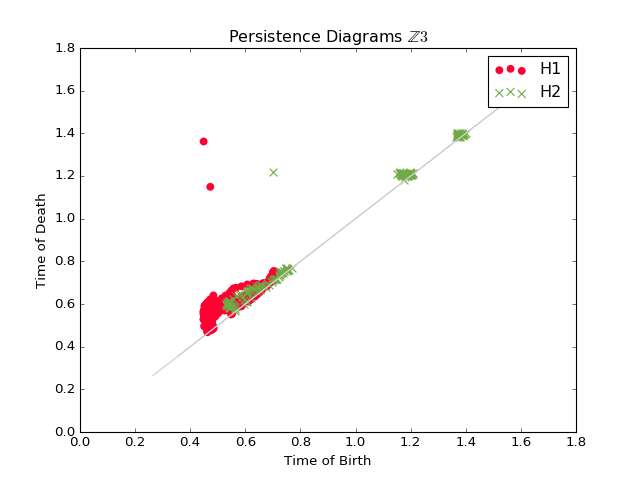

In [6]:
(X, FrameDims) = loadVideo("ClinicalAsymmetry.mp4")
X = getPCAVideo(X)
X = X[0:200, :]
#'dim':32, 'Tau':0.25, 'dT':0.25, 'derivWin':2
dim = 100
Tau = 0.25
dT = 0.5
derivWin = 5

#Take a bandpass filter in time at each pixel to smooth out noise
[X, validIdx] = getTimeDerivative(X, derivWin)

#Do the sliding window
XS = getSlidingWindowVideo(X, dim, Tau, dT)
print("XS.shape = ", XS.shape)

#Mean-center and normalize sliding window
XS = XS - np.mean(XS, 1)[:, None]
XS = XS/np.sqrt(np.sum(XS**2, 1))[:, None]

#Compute and plot persistence diagrams
print("Computing persistence diagrams...")
PDs3 = doRipsFiltration(XS, 2, coeff=3)
print("Finished computing persistence diagrams")

H1 = plotDGM(PDs3[1], color = np.array([1.0, 0.0, 0.2]), label = 'H1', sz = 50, axcolor = np.array([0.8]*3))
plt.hold(True)
H2 = plotDGM(PDs3[2], color = np.array([0.43, 0.67, 0.27]), marker = 'x', sz = 50, label = 'H2', axcolor = np.array([0.8]*3))
#plt.legend(handles=[H1, H2])
plt.title("Persistence Diagrams $\mathbb{Z}3$")
plt.legend(handles=[H1, H2])

<p>
Notice how this time there is a strong 2D d
</p>

<h1>Summary</h1>
<ul>
<li>Periodicity can be studied on general time series data, including multivariate time series such as video</li>
<li>Computational tricks, such as PCA, can be employed to make sliding window videos computationally tractable</li>
</ul>